In [1]:
import pandas as pd

labels_df = pd.read_csv('isic_balanced_dataset/labels.csv')
labels_df.head()

,isic_id,target
0,ISIC_8774025,0
1,ISIC_9972877,1
2,ISIC_0967659,0
3,ISIC_6623310,0
4,ISIC_0420491,0


In [2]:
labels_df['target'].value_counts()

target
0    1000
1     393
Name: count, dtype: int64

In [3]:
from PIL import Image
import os

image_dir = 'isic_balanced_dataset/images'


def load_image(image_id, image_dir):
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    image = Image.open(image_path)
    return image

In [4]:
images = []
labels = []

for _, row in labels_df.iterrows():
    image_id = row['isic_id']
    label = row['target']
    image = load_image(image_id, image_dir)
    images.append(image)
    labels.append(label)

print(f"Loaded {len(images)} images with {len(labels)} labels.")

Loaded 1393 images with 1393 labels.


In [5]:
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
def labels2text(label):
    return "Benign" if label==0 else "Malignant"

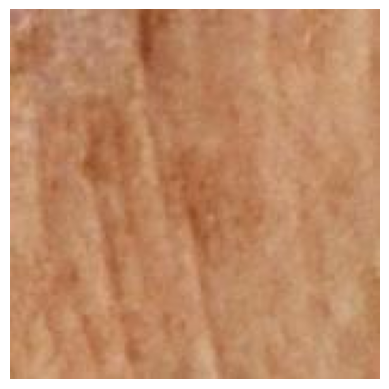

Benign


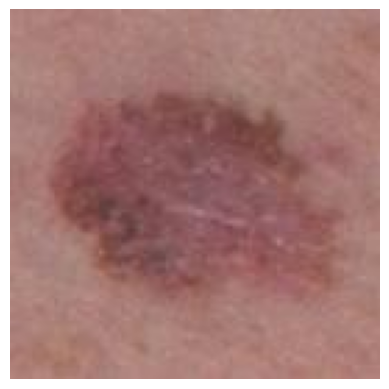

Malignant


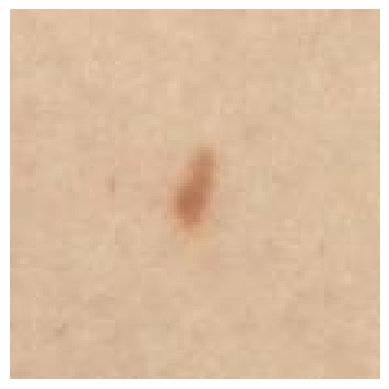

Benign


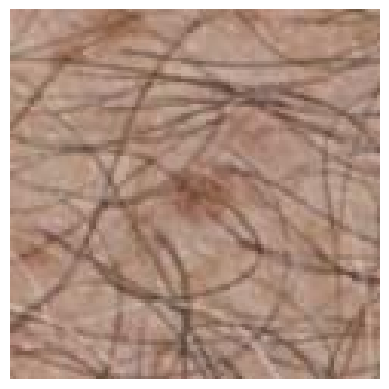

Benign


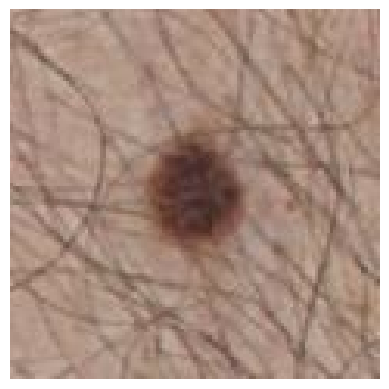

Benign


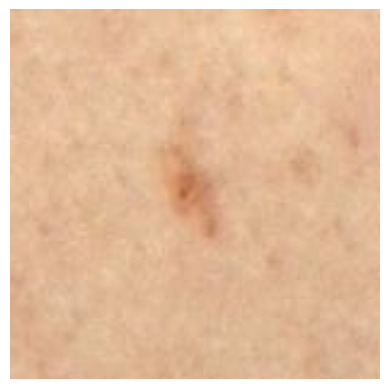

Benign


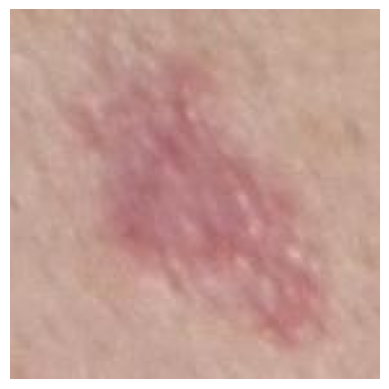

Malignant


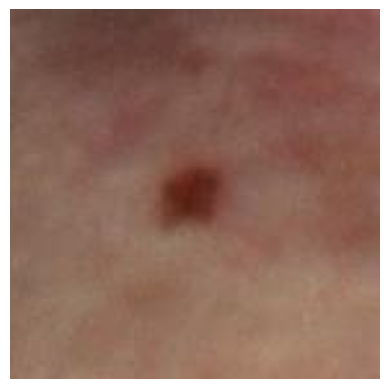

Benign


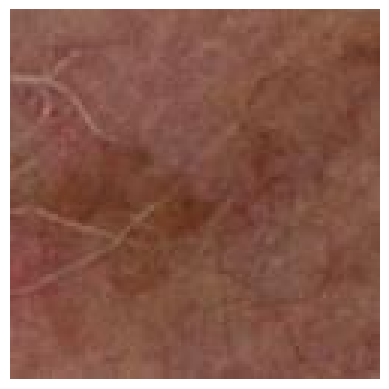

Benign


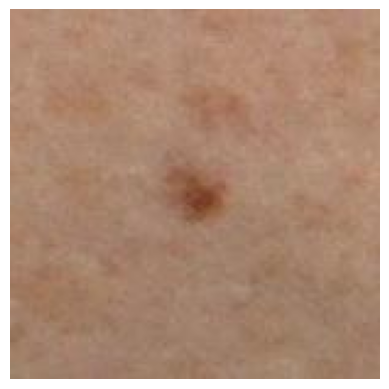

Benign


In [7]:
for i in range(10):
    show_image(images[i])
    print(labels2text(labels[i]))

In [8]:
import numpy as np

for _ in range(10):
    random_image_no = np.random.randint(1, 500)
    print(images[random_image_no].size)

(137, 137)
(123, 123)
(131, 131)
(133, 133)
(131, 131)
(139, 139)
(121, 121)
(101, 101)
(125, 125)
(123, 123)


(111, 111)


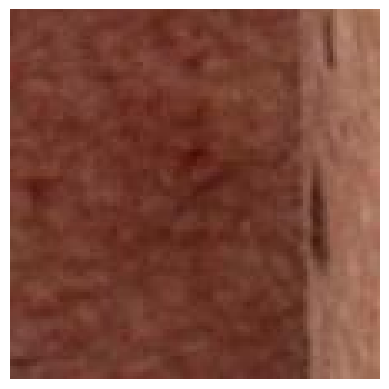

In [9]:
test_image = images[132]
print(test_image.size)
show_image(test_image)

(155, 155)


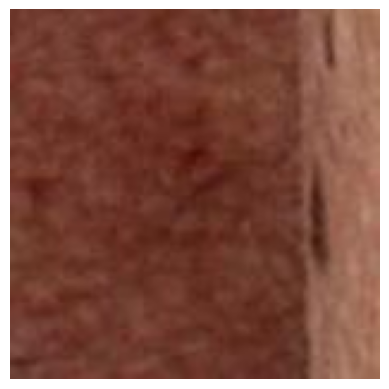

In [10]:
test_image_resized = test_image.resize((155,155))
print(test_image_resized.size)
show_image(test_image_resized)

(128, 128)


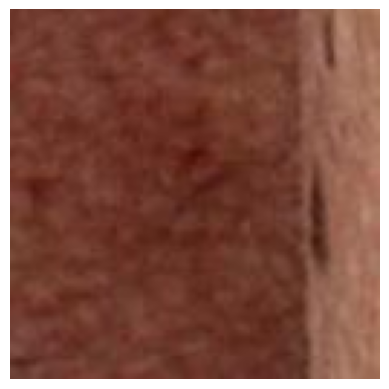

In [11]:
test_image_resized = test_image.resize((128,128))
print(test_image_resized.size)
show_image(test_image_resized)

In [12]:
def resize_images(images, target_size=(128, 128)):
    resized_images = []
    for img in images:
        if img.size != target_size:
            resized_img = img.resize(target_size)
            resized_images.append(resized_img)
        else:
            resized_images.append(img)
    return resized_images

In [13]:
resized_images = resize_images(images)

In [14]:
class_1_indices = labels_df[labels_df['target'] == 1].index
class_1_images = [resized_images[i] for i in class_1_indices]

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [16]:
class1_images_augmented = []
# generate 3x the number of original images
for img in class_1_images:
    img = np.expand_dims(img, 0) 
    for _ in range(2):
        for batch in datagen.flow(img, batch_size=1):
            class1_images_augmented.append(batch[0])
            break

In [17]:
type(class1_images_augmented[0])

numpy.ndarray

In [18]:
def numpy_to_pil(numpy_images):
    pil_images = [Image.fromarray((img * 255).astype(np.uint8)) for img in numpy_images]
    return pil_images

class1_images_augmented_pil = numpy_to_pil(class1_images_augmented)

In [19]:
print(f"New number of images in class-1: {len(class1_images_augmented_pil)}")

New number of images in class-1: 786


In [20]:
all_images = resized_images + class1_images_augmented_pil

In [21]:
new_ids = [f'augmented_{i}' for i in range(len(class1_images_augmented_pil))]
augmented_labels_df = pd.DataFrame({
    'isic_id': new_ids,
    'target': [1] * len(class1_images_augmented_pil)
})
labels_df = pd.concat([labels_df, augmented_labels_df], ignore_index=True)

In [22]:
print(f"Total number of images: {len(all_images)}")
print(f"Total number of labels: {len(labels_df)}")

Total number of images: 2179
Total number of labels: 2179


In [23]:
labels_df.tail(10)

,isic_id,target
2169,augmented_776,1
2170,augmented_777,1
2171,augmented_778,1
2172,augmented_779,1
2173,augmented_780,1
2174,augmented_781,1
2175,augmented_782,1
2176,augmented_783,1
2177,augmented_784,1
2178,augmented_785,1


In [24]:
from sklearn.utils import shuffle

images_with_labels = list(zip(all_images, labels_df.to_dict('records')))
shuffled_images_with_labels = shuffle(images_with_labels, random_state=42)
shuffled_images = [img for img, _ in shuffled_images_with_labels]
shuffled_labels_dicts = [label for _, label in shuffled_images_with_labels]
shuffled_labels_df = pd.DataFrame(shuffled_labels_dicts)

In [25]:
shuffled_labels_df.tail(10)

,isic_id,target
2169,augmented_89,1
2170,ISIC_1456138,0
2171,ISIC_9972649,1
2172,ISIC_7424463,0
2173,augmented_776,1
2174,augmented_245,1
2175,ISIC_1460260,0
2176,ISIC_6843477,0
2177,ISIC_0202043,0
2178,ISIC_0279372,1


In [26]:
import os

output_dir = 'isic_balanced_dataset/processed_images'
os.makedirs(output_dir, exist_ok=True)

for i, img in enumerate(shuffled_images):
    img_filename = os.path.join(output_dir, f'image_{i}.png')
    img.save(img_filename)

labels_csv_filename = os.path.join('isic_balanced_dataset', 'updated_labels.csv')
shuffled_labels_df.to_csv(labels_csv_filename, index=False)